In [1]:
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.utils import shuffle

# Labelilng

In [3]:
# PATHS
# path to the folder containing the subfolders with the training images
trainpath = '/kaggle/input/intel-image-classification/seg_train/seg_train'
# path to the folder containing the subfolders with the testing images
testpath = '/kaggle/input/intel-image-classification/seg_test/seg_test'
predpath = '/kaggle/input/intel-image-classification/seg_pred/seg_pred'

In [4]:
# Create a dictionary to change text labels into int numerical labels
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
class_labels = {class_name:i for i, class_name in enumerate(class_names)}

print(class_labels)

{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


In [5]:
# def for labeling 

import os
from PIL import Image
IMAGE_SIZE = (150, 150)

def labeling(folder_path, images, labels):
    # loop through all subfolders in the folder_path
    for label in os.listdir(folder_path):
        # get the path to the subfolder
        label_path = os.path.join(folder_path, label)

        # convert label text to label number
        label_number = class_labels[label]

        # loop through all images in subfolder
        for file_name in os.listdir(label_path):
            # upload image using Pillow
            image = Image.open(os.path.join(label_path, file_name))

            # resize image to desired size
            image = image.resize(IMAGE_SIZE)

            # convert the image to a Numpy array  
            image = np.array(image)

            # add image to testing_image list
            images.append(image)

            # add image label to testing_label list
            labels.append(label_number)
    # convert the images and labels list to numpy array
    images = np.array(images, dtype='float32')
    labels = np.array(labels, dtype='int32')
    
    return images, labels



In [6]:
# Training labeling
# list to store the images and their labels
training_images = []
training_labels = []
x_train, y_train = labeling(trainpath, training_images, training_labels)

# Testing labeling
# list to store the images and their labels
testing_images = []
testing_labels = []
x_test, y_test = labeling(testpath, testing_images, testing_labels)


In [7]:
del training_images
del training_labels
del testing_images
del testing_labels



# Data visualization

In [ ]:
plt.imshow(training_images[5])

In [ ]:
print(training_labels[5])

# Data prepatation

In [8]:
# Find the unique numbers from the train labels
num_clases = len(np.unique(y_train))

# Change the labels from categorical to one-hot encoding
y_train = to_categorical(y_train, num_clases)
y_test = to_categorical(y_test, num_clases)


In [ ]:
# Visualize y_train after one hot encoding
y_train[0]

### Normalization

In [9]:
# Using Z-score normalization to converge faster and improve accuracy
mean = np.mean(x_train)
std = np.std(x_train)


x_train = (x_train - mean) / (std+1e-7)
x_test = (x_test - mean) / (std+1e-7)


### validation data

In [10]:

# Split train and test
x_train, x_valid , y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1, random_state=13)

In [11]:
print('train;', x_train.shape[0])
print('val;', x_valid.shape[0])
print('test;', x_test.shape[0])

train; 12630
val; 1404
test; 3000


# Building the convnet model

In [12]:
base_filtros = 32
w_regulatizer = 1e-4

In [13]:
x_train.shape[1:]

(150, 150, 3)

*op2*

In [14]:
model = Sequential()
## conv 1
model.add(Conv2D(base_filtros, (3,3), padding='same', kernel_regularizer=regularizers.l2(w_regulatizer), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(BatchNormalization())

## conv 2
model.add(Conv2D(base_filtros, (3,3), padding='same', kernel_regularizer=regularizers.l2(w_regulatizer)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

## conv 3
model.add(Conv2D(2*base_filtros, (3,3), padding='same', kernel_regularizer=regularizers.l2(w_regulatizer)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

## conv 4
model.add(Conv2D(2*base_filtros, (3,3), padding='same', kernel_regularizer=regularizers.l2(w_regulatizer)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

## conv 5
model.add(Conv2D(4*base_filtros, (3,3), padding='same', kernel_regularizer=regularizers.l2(w_regulatizer)))
model.add(Activation('relu'))
model.add(BatchNormalization())


## conv 6
model.add(Conv2D(4*base_filtros, (3,3), padding='same', kernel_regularizer=regularizers.l2(w_regulatizer)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

## Clasificacion - Flatten

model.add(Flatten())
model.add(Dense(num_clases,activation='softmax'))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 activation (Activation)     (None, 150, 150, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 150, 150, 32)      0         
                                                                 
 batch_normalization_1 (Batc  (None, 150, 150, 32)     128       
 hNormalization)                                        

## Data augmentation

In [15]:
datagen = ImageDataGenerator(rotation_range=15,
                  width_shift_range=0.1,
                  height_shift_range=0.1,
                  horizontal_flip=True,
                  vertical_flip=True)

## Compiling

In [16]:
from tensorflow.keras import optimizers

In [17]:
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(),
             metrics=['accuracy'])

## Callbacks

In [18]:
chekcpoint = ModelCheckpoint('mi_mejor_modelo.hdf5',verbose=1,save_best_only=True, monitor = 'val_accuracy')

## Training

In [19]:
hist = model.fit(datagen.flow(x_train, y_train, batch_size=128),
          callbacks=[chekcpoint],
          steps_per_epoch=x_train.shape[0] // 128, 
          epochs=50,
          verbose=1,
          validation_data=(x_valid, y_valid)
         )

Epoch 1/50


2023-05-16 00:54:29.828809: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


98/98 [==============================] - ETA: 0s - loss: 3.8303 - accuracy: 0.4520
Epoch 1: val_accuracy improved from -inf to 0.18162, saving model to mi_mejor_modelo.hdf5
98/98 [==============================] - 98s 873ms/step - loss: 3.8303 - accuracy: 0.4520 - val_loss: 5.2446 - val_accuracy: 0.1816
Epoch 2/50
98/98 [==============================] - ETA: 0s - loss: 1.9500 - accuracy: 0.5536
Epoch 2: val_accuracy improved from 0.18162 to 0.30769, saving model to mi_mejor_modelo.hdf5
98/98 [==============================] - 81s 821ms/step - loss: 1.9500 - accuracy: 0.5536 - val_loss: 3.2042 - val_accuracy: 0.3077
Epoch 3/50
98/98 [==============================] - ETA: 0s - loss: 1.5978 - accuracy: 0.6036
Epoch 3: val_accuracy improved from 0.30769 to 0.41952, saving model to mi_mejor_modelo.hdf5
98/98 [==============================] - 81s 822ms/step - loss: 1.5978 - accuracy: 0.6036 - val_loss: 2.7593 - val_accuracy: 0.4195
Epoch 4/50
98/98 [==============================] - ETA: 

In [20]:
def graph_loss_in_epochs(hist, save_image_filename, title):
    training_loss = hist.history['loss']
    test_loss = hist.history['val_loss'] #[10 9 8 5 6 7] 3
    # Create count of the number of epochs
    epoch_count = range(1, len(training_loss) + 1) #[1 2 3 4 5 6]
    # Visualize loss history
    plt.title(title)
    plt.plot(epoch_count, training_loss, 'r--')
    plt.plot(epoch_count, test_loss, 'b-')
    plt.legend(['Training Loss', 'Test Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.savefig(save_image_filename) 
    plt.axvline(x = epoch_count[test_loss.index(min(test_loss))], color = 'c', linestyle="dotted")
    plt.show()

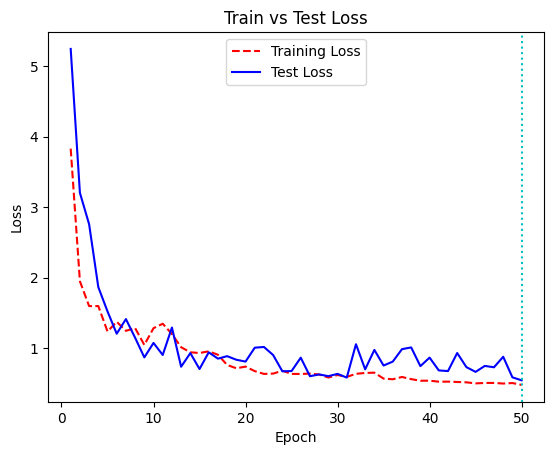

In [21]:
graph_loss_in_epochs(hist, 'train_vs_test_loss.png', 'Train vs Test Loss')

In [29]:
# Defining accuracy and loss plot funtion
def plot_loss_accuracy(hist, len_epochs):
  epochs = len_epochs
  acc = hist.history['accuracy']
  val_acc = hist.history['val_accuracy']

  loss = hist.history['loss']
  val_loss = hist.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, 'r--', label='Training Accuracy')
  plt.plot(epochs_range, val_acc,'b-' , label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, 'r--', label='Training Loss')
  plt.plot(epochs_range, val_loss, 'b-', label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
plt.savefig('plot.png')
plt.show()

<Figure size 640x480 with 0 Axes>

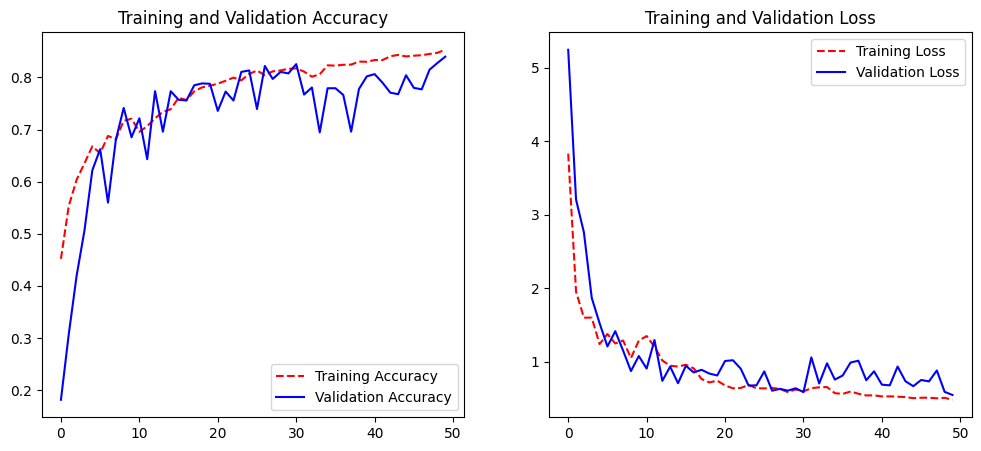

In [24]:
# call the function to plot the curves
plot_loss_accuracy(hist, 50)

In [25]:
model2 = model

In [26]:
model2.load_weights('./mi_mejor_modelo.hdf5')

In [27]:
model2.evaluate(x_test,y_test)

94/94 [==============================] - 3s 28ms/step - loss: 0.5432 - accuracy: 0.8297


[0.5431879758834839, 0.8296666741371155]

# Guardar metricas de entrenamiento

In [31]:
import csv
# Extrae las métricas de rendimiento para cada época desde el objeto de historial:
train_loss = hist.history['loss']
train_acc = hist.history['accuracy']
val_loss = hist.history['val_loss']
val_acc = hist.history['val_accuracy']

# Abre el archivo CSV y escribe las métricas de rendimiento:
with open('metrics.csv', 'a') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['train_loss', 'train_acc', 'val_loss', 'val_acc'])
    for i in range(len(train_loss)):
        writer.writerow([train_loss[i], train_acc[i], val_loss[i], val_acc[i]])


In [32]:
import pickle
from pickle import dump
from pickle import load

def save_model(model, model_file_name):
    dump(model, open(model_file_name, 'wb'))
    
def load_model(model_file_name):
    return load(model_file_name, 'rb')
    

In [33]:
model_file_name = 'pickle_model_epoch50.pkl'
save_model(model, model_file_name)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......activation_4
.........vars
......activation_5
.........vars
......batch_normalization
.........vars
............0
............1
............2
............3
......batch_normalization_1
.........vars
............0
............1
............2
............3
......batch_normalization_2
.........vars
............0
............1
............2
............3
......batch_normalization_3
.........vars
............0
............1
............2
............3
......batch_normalization_4
.........vars
............0
............1
............2
............3
......batch_normalization_5
.........vars
............0
............1
............2
............3
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
.